<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Predicting Shots Made Per Game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties — ridge, lasso, and elastic net — to try and predict how many shots Kobe Bryant made per game during his career.

The Kobe Shots data set contains hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model, considering the limited number of observations (games) we have available. Plus, many of the predictors have significant multicollinearity. 


**Warning:** Some of these calculations are computationally expensive and may take a while to execute. It may be worthwhile to only use a portion of the data to perform these calculations, especially if you've experienced kernel issues in the past.

---

### 1) Load packages and data.

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
kobe = pd.read_csv('./datasets/kobe_superwide_games.csv')

---

### 2) Examine the data.

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why might regularization be particularly useful for modeling this data?

In [3]:
# 645 columns
kobe.shape

(1558, 645)

In [4]:
kobe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Columns: 645 entries, SHOTS_MADE to CAREER_GAME_NUMBER
dtypes: float64(640), int64(5)
memory usage: 7.7 MB


In [5]:
kobe.describe()

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
count,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,...,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000
mean,7.358793,0.500642,0.001284,0.001284,0.000642,0.000642,0.001284,0.001284,0.000642,0.000642,...,0.000064,0.006207,0.002047,0.000032,0.014149,0.000050,0.000433,0.031766,42.946727,780.486521
std,3.471180,0.500160,0.035817,0.035817,0.025335,0.025335,0.035817,0.035817,0.025335,0.025335,...,0.001791,0.022033,0.011133,0.001267,0.041313,0.001390,0.004902,0.049402,26.048206,449.923227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,391.250000
50%,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,780.500000
75%,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,63.000000,1169.750000
max,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.050000,0.250000,0.133333,0.050000,0.533333,0.041667,0.111111,0.352941,105.000000,1559.000000


In [6]:
kobe.isnull().sum()

SHOTS_MADE                                 0
AWAY_GAME                                  0
SEASON_OPPONENT:atl:1996-97                0
SEASON_OPPONENT:atl:1997-98                0
SEASON_OPPONENT:atl:1999-00                0
                                          ..
ACTION_TYPE:turnaround_finger_roll_shot    0
ACTION_TYPE:turnaround_hook_shot           0
ACTION_TYPE:turnaround_jump_shot           0
SEASON_GAME_NUMBER                         0
CAREER_GAME_NUMBER                         0
Length: 645, dtype: int64

---

### 3) Create predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

**Answer:**

* To make all the variables weighted proportionately to each other

In [7]:
# create X and y
X = kobe.drop('SHOTS_MADE', axis=1)
y = kobe['SHOTS_MADE']

**_Train test split, random_state=42_**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**_Scale values for regularisation_**

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
# Relabeling scaled data as "Z"
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

**_Instantiate, fit model_**

In [11]:
lr=LinearRegression()
lr.fit(Z_train, y_train)

LinearRegression()

**_Make predictions_**

In [12]:
y_train_pred = lr.predict(Z_train)
y_test_pred = lr.predict(Z_test)

**_Evaluate model_**

In [13]:
print(f'train_r2: {r2_score(y_train, y_train_pred)}')
print(f'test_r2: {r2_score(y_test, y_test_pred)}')

train_r2: 0.8162579739466194
test_r2: -1.5623889101450643e+26


In [14]:
lr.score(Z_train, y_train)

0.8162579739466194

In [15]:
lr.score(Z_test, y_test)

-1.5623889101450643e+26

In [16]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'train_mse: {train_mse}')
print(f'test_mse: {test_mse}')

train_mse: 2.2359742436329113
test_mse: 1.8142416881715445e+27


In [17]:
mse_perc_diff = abs((train_mse - test_mse)/ train_mse)*100
print(mse_perc_diff,'%')

8.113875610766632e+28 %


In [18]:
cross_val_score(lr, Z_train, y_train, cv=10)

array([-6.32858031e+28, -1.13072836e+28, -1.18315024e+28, -1.37423156e+28,
       -6.50179459e+27, -1.52182024e+28, -8.14304195e+27, -1.76482563e+28,
       -7.04502595e+27, -3.56460364e+28])

In [19]:
cross_val_score(lr, Z_train, y_train, cv=10).mean()

-1.9036926224040674e+28

---

### 5) Find an optimal value for the ridge regression alpha using `RidgeCV`.

Go to the documentation and [read how RidgeCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

> *Hint: Once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that ridge performs best when searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit.


In [20]:
# Set up a list of ridge alphas to check.
# np.logspace generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=np.logspace(0, 5, 100), scoring='r2', cv=5)

ridge_cv = ridge_model.fit(Z_train, y_train)

In [21]:
# Generate predictions.
ridge_cv_preds = ridge_cv.predict(Z_test)
ridge_cv_preds_train = ridge_cv.predict(Z_train)

In [22]:
# Here is the optimal value of alpha
ridge_cv.alpha_

1204.5035402587823

---

### 6) Cross-validate the ridge regression $R^2$ with the optimal alpha.

Is it better than the linear regression? If so, why might this be?

In [23]:
ridge_model = RidgeCV(alphas=[1204.5035402587823], scoring='r2', cv=5)

ridge_cv = ridge_model.fit(Z_train, y_train)

In [24]:
print(ridge_cv.score(Z_train, y_train))
print(ridge_cv.score(Z_test, y_test))

0.7737117268864451
0.6143511503103276


In [25]:
# Score of base estimator with best alpha
ridge_cv.best_score_

0.6177971613268218

In [26]:
cross_val_score(ridge_cv, Z_train, y_train, cv=5).mean()

0.6177971613268218

In [27]:
train_mse = mean_squared_error(y_train, ridge_cv_preds_train)
test_mse = mean_squared_error(y_test, ridge_cv_preds)
print(f'train_mse: {train_mse}')
print(f'test_mse: {test_mse}')

train_mse: 2.753723582927527
test_mse: 4.478143793515812


In [28]:
# percentage difference in error for performance on train vs test data
mse_perc_diff = abs((train_mse - test_mse)/ train_mse)*100
print(mse_perc_diff,'%')

62.62139821437803 %


---

### 7) Find an optimal value for lasso regression alpha using `LassoCV`.

Go to the documentation and [read how LassoCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It is very similar to `RidgeCV`.

> *Hint: Again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that lasso, unlike ridge, performs best when searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide what alphas to use itself by setting the keyword argument `n_alphas=` to however many alphas you want it to search over. We recommend letting scikit-learn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if it's working, set `verbose =1`._

In [29]:
# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(n_alphas=100, cv=5, max_iter=50000)

lasso_cv.fit(Z_train, y_train);

In [30]:
# Generate predictions.
lasso_cv_preds = lasso_cv.predict(Z_test)
lasso_cv_preds_train = lasso_cv.predict(Z_train)

In [31]:
lasso_cv.alpha_

0.1064145192972607

---

### 8) Cross-validate the lasso $R^2$ with the optimal alpha.

Is it better than the linear regression? Is it better than ridge? What do the differences in results imply about the issues with the data set?

In [32]:
# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=[0.1064145192972607], cv=5, max_iter=50000)

lasso_cv.fit(Z_train, y_train);

In [33]:
print(lasso_cv.score(Z_train, y_train))
print(lasso_cv.score(Z_test, y_test))

0.6867406826184943
0.6405386925165863


In [34]:
cross_val_score(lasso_cv, Z_train, y_train, cv=5).mean()

0.6449856652067653

In [35]:
train_mse = mean_squared_error(y_train, lasso_cv_preds_train)
test_mse = mean_squared_error(y_test, lasso_cv_preds)
print(f'train_mse: {train_mse}')
print(f'test_mse: {test_mse}')

train_mse: 3.8120825174725277
test_mse: 4.174054776544135


In [36]:
# percentage difference in error for performance on train vs test data
mse_perc_diff = abs((train_mse - test_mse)/ train_mse)*100
print(mse_perc_diff,'%')

9.495394116274285 %


---

### 9) Look at the coefficients for variables in the lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original data set are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** If you only fit the lasso within `cross_val_score`, you'll have to refit it outside of that function to pull out the coefficients.

In [37]:
lasso_cv.coef_

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.17443695e-02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

In [38]:
# sort values in descending order using numpy
np.flip(np.sort(abs(lasso_cv.coef_))) 

array([1.45701649e+00, 6.17922441e-01, 4.82578445e-01, 3.63605304e-01,
       2.61659603e-01, 1.78533073e-01, 1.63675949e-01, 1.04014198e-01,
       1.02217149e-01, 1.01721252e-01, 9.42410250e-02, 9.17443695e-02,
       9.07653546e-02, 9.00323623e-02, 6.32199527e-02, 6.10565887e-02,
       5.47886476e-02, 5.02129429e-02, 4.87530664e-02, 4.78729999e-02,
       4.25047269e-02, 4.04777159e-02, 3.91190254e-02, 3.67985430e-02,
       3.61427016e-02, 3.25404033e-02, 3.17811065e-02, 2.82411628e-02,
       2.76748073e-02, 2.75665722e-02, 2.65615736e-02, 2.59884508e-02,
       2.59689499e-02, 2.24076739e-02, 1.98188158e-02, 1.95648194e-02,
       1.88709559e-02, 1.87653385e-02, 1.82334029e-02, 1.76088056e-02,
       1.51552008e-02, 1.50572225e-02, 1.48560674e-02, 1.45780253e-02,
       1.44418481e-02, 1.36173734e-02, 1.30455900e-02, 1.24550615e-02,
       1.13613298e-02, 1.03818035e-02, 9.06707069e-03, 8.49522784e-03,
       6.29738635e-03, 5.67205442e-03, 4.66966048e-03, 3.83880030e-03,
      

In [39]:
# Percent of the variables in the original data "zeroed-out" by the lasso
d = len(lasso_cv.coef_)

count = 0
for i in lasso_cv.coef_:
    if i != 0:
        count += 1
print(count)        
print()
print(((d-count)/d)*100)
# around 90.2% of variables have been zeroed-out by lasso

63

90.21739130434783


In [40]:
# number of columns included in lasso regression model
lasso_cv.n_features_in_

644

### What are the most important predictors for how many shots Kobe made in a game?
---

In [41]:
# get the names of the features that lasso did not zero-out
np.array(X.columns)[abs(lasso_cv.coef_) > 0]

array(['SEASON_OPPONENT:bos:2015-16', 'SEASON_OPPONENT:dal:2004-05',
       'SEASON_OPPONENT:dal:2007-08', 'SEASON_OPPONENT:dal:2008-09',
       'SEASON_OPPONENT:dal:2012-13', 'SEASON_OPPONENT:den:2007-08',
       'SEASON_OPPONENT:det:2009-10', 'SEASON_OPPONENT:det:2011-12',
       'SEASON_OPPONENT:det:2015-16', 'SEASON_OPPONENT:gsw:2000-01',
       'SEASON_OPPONENT:gsw:2001-02', 'SEASON_OPPONENT:gsw:2004-05',
       'SEASON_OPPONENT:gsw:2010-11', 'SEASON_OPPONENT:hou:1999-00',
       'SEASON_OPPONENT:hou:2008-09', 'SEASON_OPPONENT:hou:2015-16',
       'SEASON_OPPONENT:ind:1999-00', 'SEASON_OPPONENT:ind:2002-03',
       'SEASON_OPPONENT:ind:2015-16', 'SEASON_OPPONENT:mem:2004-05',
       'SEASON_OPPONENT:mem:2009-10', 'SEASON_OPPONENT:mia:2014-15',
       'SEASON_OPPONENT:min:2006-07', 'SEASON_OPPONENT:njn:2011-12',
       'SEASON_OPPONENT:noh:2011-12', 'SEASON_OPPONENT:nyk:2008-09',
       'SEASON_OPPONENT:nyk:2009-10', 'SEASON_OPPONENT:okc:2014-15',
       'SEASON_OPPONENT:orl:2000-0

---

### 10) Find an optimal value for elastic net regression alpha using `ElasticNetCV`.

Go to the documentation and [read how ElasticNetCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note that here you'll be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: Strength of regularization.
- `l1_ratio`: Amount of ridge vs. lasso (0 = all ridge, 1 = all lasso).
    
Do not include 0 in the search for `l1_ratio` — it won't allow it and will break.

You can use `n_alphas` for the alpha parameters instead of setting your own values, which we highly recommend.

Also, be careful setting too many l1_ratios over cross-validation folds in your search. It can take a long time if you choose too many combinations and, for the most part, there are diminishing returns in this data.

In [42]:
enet_model = ElasticNetCV(n_alphas=500, cv=5, l1_ratio=[.5, .6, .7, .8, .9, .99, 1])

enet_cv = enet_model.fit(Z_train, y_train)

In [43]:
# Generate predictions.
enet_cv_preds = enet_cv.predict(Z_test)
enet_cv_preds_train = enet_cv.predict(Z_train)

In [44]:
# Here is the optimal value of alpha
enet_cv.alpha_

0.10620640347311808

In [45]:
# the optimal ratio of lasso vs ridge regression in model 
# the elastic model chose 100% lasso regression
enet_cv.l1_ratio_

1.0

---

### 11) Cross-validate the elastic net $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the ridge and lasso regularized regressions?

In [46]:
enet_model = ElasticNetCV(alphas=
[0.10620640347311808], cv=5, l1_ratio=1.0)

enet_cv = enet_model.fit(Z_train, y_train)

In [47]:
print(enet_cv.score(Z_train, y_train))
print(enet_cv.score(Z_test, y_test))

0.6869292746416295
0.6405561734862535


In [48]:
cross_val_score(enet_cv, Z_train, y_train, cv=5).mean()

0.6449862198803513

In [49]:
train_mse = mean_squared_error(y_train, enet_cv_preds_train)
test_mse = mean_squared_error(y_test, enet_cv_preds)
print(f'train_mse: {train_mse}')
print(f'test_mse: {test_mse}')

train_mse: 3.809787523151728
test_mse: 4.17385178800707


In [50]:
# percentage difference in error for performance on train vs test data
mse_perc_diff = abs((train_mse - test_mse)/ train_mse)*100
print(mse_perc_diff,'%')

9.556025438241818 %


### Answer:
* The result ElasticNet model after hyperparameter tuning is essentially the same as the lasso regression model
* So both performance for ElasticNet model and Lasso regression model on the current available dad is the same
* Ridge regression model has poorer performance 

---

### 12. [Bonus] Compare the residuals for ridge and lasso visually.


In [51]:
# A: Maybe a jointplot?

In [52]:
# ridge residuals
# use performance on test set
ridge_resid = y_test - ridge_cv_preds

In [53]:
# lasso residuals
# use performance on test set
lasso_resid = y_test - lasso_cv_preds

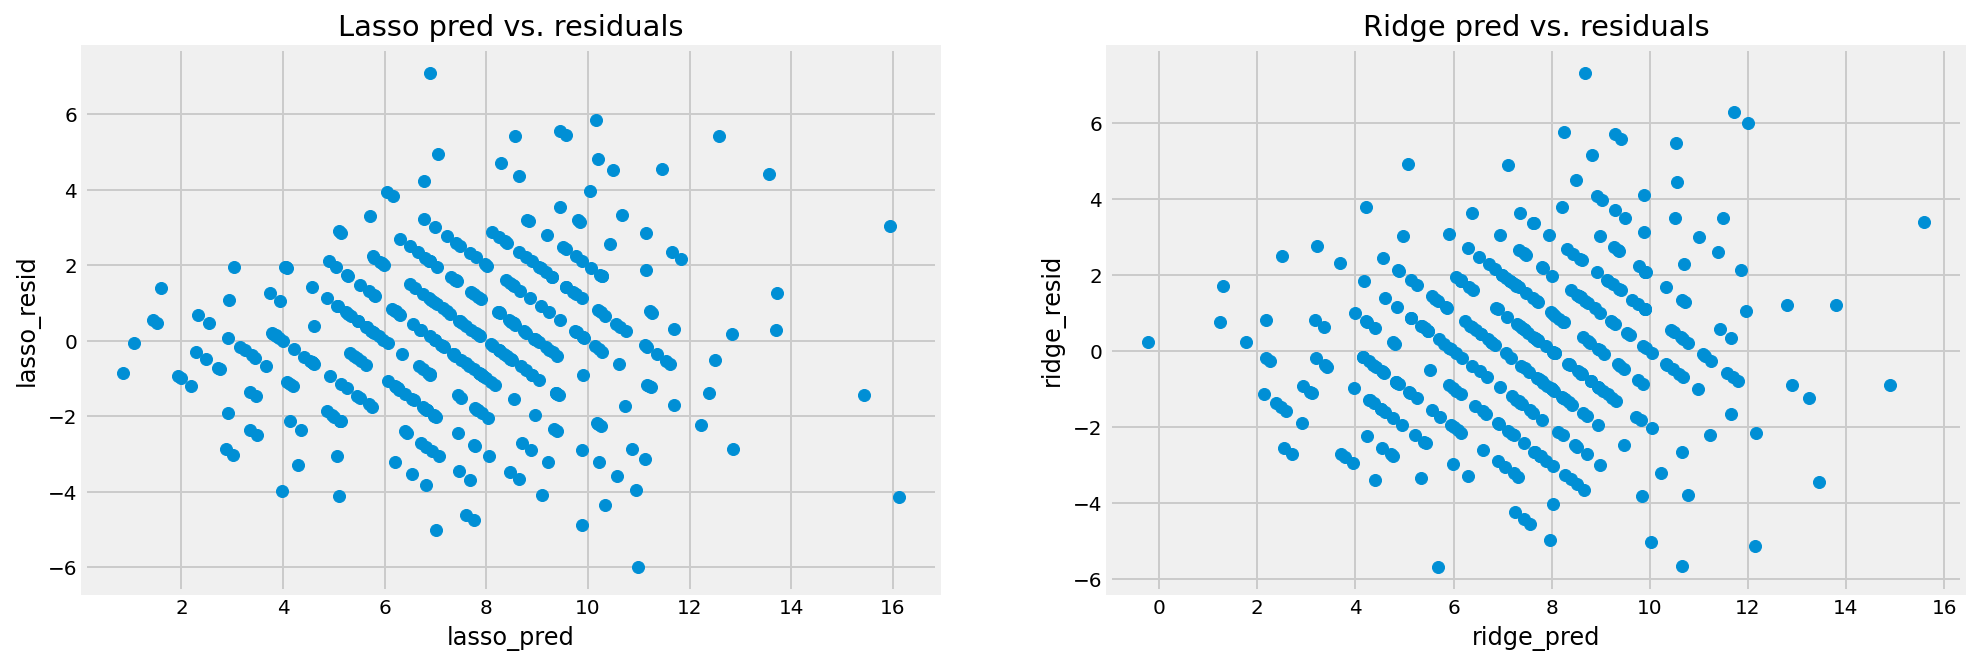

In [54]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(lasso_cv_preds, lasso_resid)
plt.xlabel('lasso_pred')
plt.ylabel('lasso_resid')
plt.title('Lasso pred vs. residuals');

plt.subplot(1,2,2)
plt.scatter(ridge_cv_preds, ridge_resid)
plt.xlabel('ridge_pred')
plt.ylabel('ridge_resid')
plt.title('Ridge pred vs. residuals');

In [55]:
# combine predictions and residuals into a dataframe
# residuals on same column
# predictions on another column
# additional column for type to differentiate the values between ridge and lasso
ridge_r_df = ridge_resid.to_frame()
ridge_r_df.reset_index(drop=True, inplace=True)

In [56]:
ridge_r_df.rename(columns={'SHOTS_MADE': 'ridge_r'}, inplace=True)
ridge_r_df.head()

,ridge_r
0,0.063163
1,0.785377
2,0.509521
3,-2.125924
4,-1.047904


In [57]:
lasso_r_df = lasso_resid.to_frame()
lasso_r_df.reset_index(drop=True, inplace=True)

In [58]:
lasso_r_df.rename(columns={'SHOTS_MADE': 'lasso_r'}, inplace=True)
lasso_r_df.head()

,lasso_r
0,-0.232652
1,1.054335
2,-0.167830
3,-0.844439
4,-2.175340


In [59]:
# preds are numpy ndarrays, so need to convert to dataframe
lasso_df = pd.DataFrame(lasso_cv_preds, columns=['lasso_p'])
ridge_df = pd.DataFrame(ridge_cv_preds, columns=['ridge_p'])

In [60]:
lasso_merge = pd.merge(left=lasso_df,
                      right=lasso_r_df,
                      how='outer',
                      left_index=True,
                      right_index=True)
lasso_merge.head()

,lasso_p,lasso_r
0,9.232652,-0.232652
1,3.945665,1.054335
2,11.167830,-0.167830
3,6.844439,-0.844439
4,10.175340,-2.175340


In [61]:
lasso_merge['type'] = 'lasso'
lasso_merge.head()

,lasso_p,lasso_r,type
0,9.232652,-0.232652,lasso
1,3.945665,1.054335,lasso
2,11.167830,-0.167830,lasso
3,6.844439,-0.844439,lasso
4,10.175340,-2.175340,lasso


In [62]:
# rename columns
lasso_merge.rename(columns={'lasso_p': 'predictions',
                           'lasso_r': 'residuals'}, inplace=True)

lasso_merge.head()

,predictions,residuals,type
0,9.232652,-0.232652,lasso
1,3.945665,1.054335,lasso
2,11.167830,-0.167830,lasso
3,6.844439,-0.844439,lasso
4,10.175340,-2.175340,lasso


In [63]:
ridge_merge = pd.merge(left=ridge_df,
                      right=ridge_r_df,
                       how='outer',
                       left_index=True,
                       right_index=True)
ridge_merge.head()

,ridge_p,ridge_r
0,8.936837,0.063163
1,4.214623,0.785377
2,10.490479,0.509521
3,8.125924,-2.125924
4,9.047904,-1.047904


In [64]:
ridge_merge['type'] = 'ridge'
ridge_merge.head()

,ridge_p,ridge_r,type
0,8.936837,0.063163,ridge
1,4.214623,0.785377,ridge
2,10.490479,0.509521,ridge
3,8.125924,-2.125924,ridge
4,9.047904,-1.047904,ridge


In [65]:
ridge_merge.rename(columns={'ridge_p':'predictions',
                           'ridge_r': 'residuals'}, inplace=True)
ridge_merge.head()

,predictions,residuals,type
0,8.936837,0.063163,ridge
1,4.214623,0.785377,ridge
2,10.490479,0.509521,ridge
3,8.125924,-2.125924,ridge
4,9.047904,-1.047904,ridge


In [66]:
plot_df = pd.concat([ridge_merge, lasso_merge])
plot_df.head()

,predictions,residuals,type
0,8.936837,0.063163,ridge
1,4.214623,0.785377,ridge
2,10.490479,0.509521,ridge
3,8.125924,-2.125924,ridge
4,9.047904,-1.047904,ridge


In [67]:
plot_df.tail()

,predictions,residuals,type
385,9.561942,1.438058,lasso
386,4.130602,-1.130602,lasso
387,7.674633,-3.674633,lasso
388,6.054962,-0.054962,lasso
389,8.643343,4.356657,lasso


In [68]:
plot_df.reset_index(drop=True, inplace=True)
plot_df.tail()

,predictions,residuals,type
775,9.561942,1.438058,lasso
776,4.130602,-1.130602,lasso
777,7.674633,-3.674633,lasso
778,6.054962,-0.054962,lasso
779,8.643343,4.356657,lasso


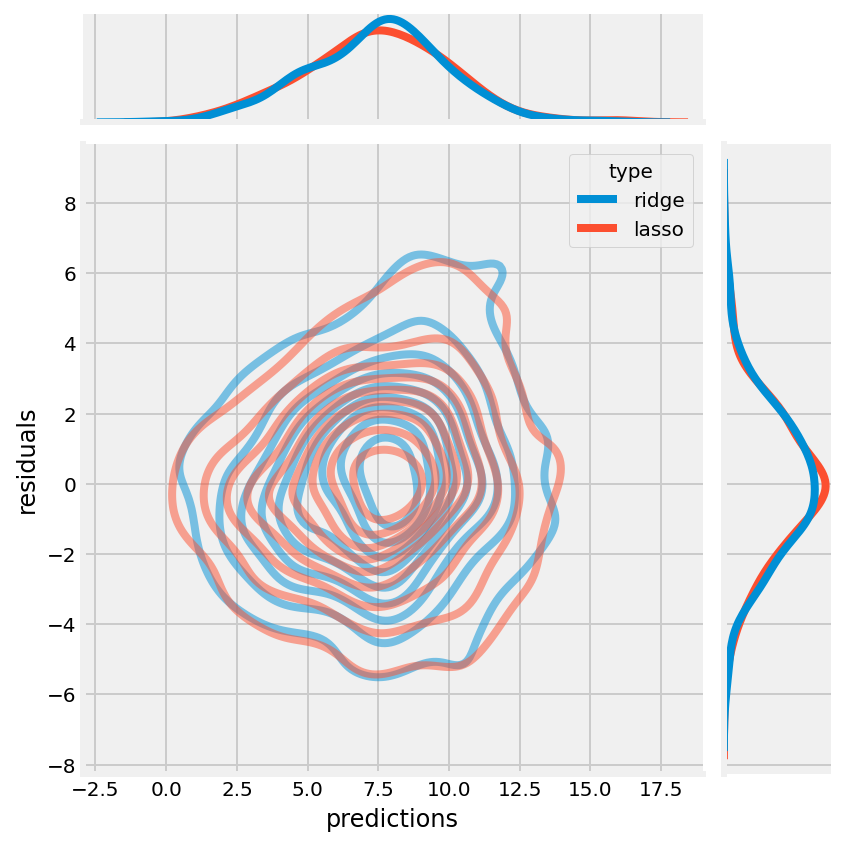

In [69]:
sns.jointplot(x='predictions', y='residuals', data=plot_df, hue='type', kind='kde', alpha=0.5);